In [1]:
from sarpyx.utils.zarr_utils import ProductHandler

Available arrays: ['az', 'raw', 'rcmc', 'rc']
Array shapes: {'az': (60643, 25742), 'raw': (60643, 25742), 'rc': (60643, 25742), 'rcmc': (60643, 25742)}


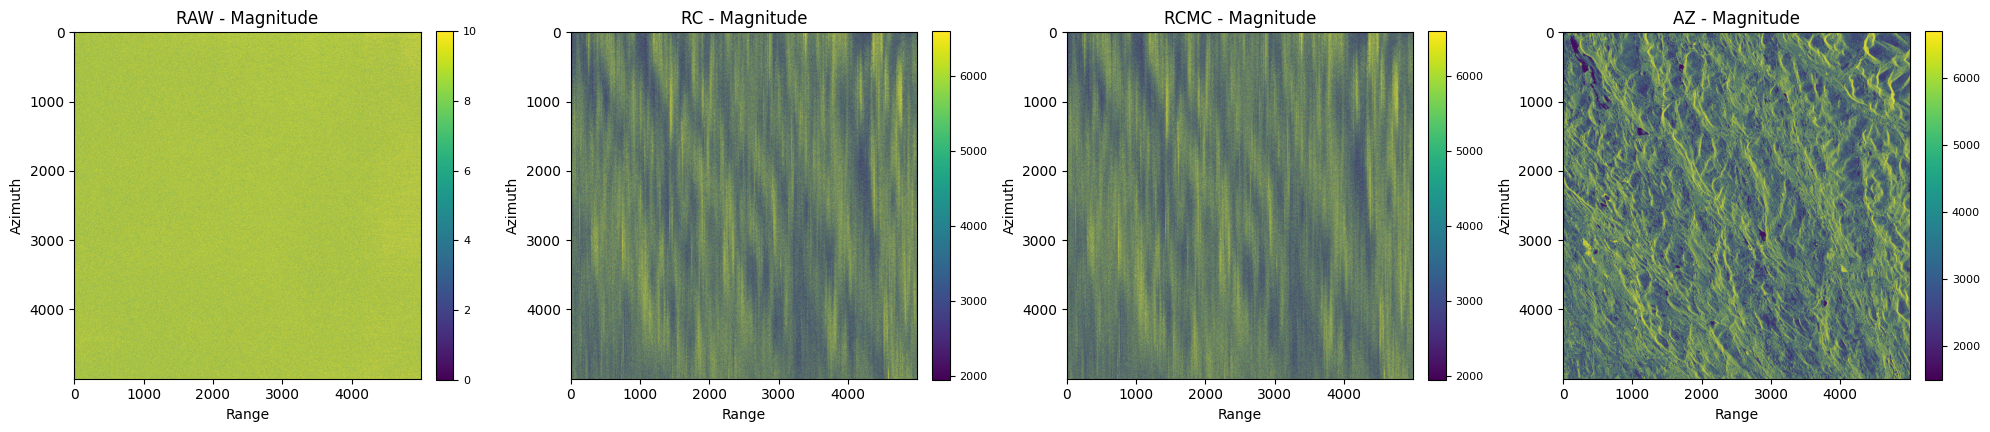

In [6]:
filepath = '/Data_large/marine/PythonProjects/SAR/sarpyx/data/focused_data_v2/s1a-s1-raw-s-hh-20160823t223515-20160823t223548-012734-0140a2.zarr'

p = ProductHandler(filepath)

# Display available arrays and basic info
print("Available arrays:", p.info['available_arrays'])
print("Array shapes:", p.array_shapes)
# Visualize all arrays with magnitude plot
p.visualize_arrays(['raw', 'rc', 'rcmc', 'az'], 
                   rows=(4000, 9000), 
                   cols=(4000, 9000), 
                   plot_type='magnitude',
                   vminmax='auto',
                   figsize=(20, 5))